# Analysis of CrowdFlower job #847908

Tong Shu Li<br>
Created on: 2016-01-07<br>
Last updated: 2016-01-08

Analysis of CrowdFlower job 847908: refinement after official BioCreative evaluation. In this task the sentence and abstract jobs were recombined back into one task, with cooccurring sentences highlighted to help draw worker attention. No NER processing was used; gold standard annotations were used instead to focus solely on the relation extraction. Test questions were generated automatically, and some were hand edited for consistency when the job was running.

This iteration of the task design sought to eliminate errors arising from lack of context issues. Previous versions where single sentences were shown resulted in false negative errors because surrounding context was not shown. However, having to show the entire abstract for all tasks greatly increases the difficulty of the task that workers need to do, and therefore it is unknown if the performance gains are worth the increase in task complexity.

In [1]:
from collections import defaultdict
import math
import matplotlib as plt
import numpy as np
import pandas as pd
import sys

In [2]:
%matplotlib inline

In [3]:
sys.path.append("..")

In [4]:
from src.filter_data import filter_data
from src.aggregate_results import aggregate_results
from src.lingpipe.file_util import save_file
from src.eval_perf import official_F_score
from src.data_model import parse_input

In [5]:
TRIPLE = ["pmid", "chemical_id", "disease_id"]

In [6]:
pd.set_option("max_colwidth", 55)

---

### Read the original gold standard for the dataset

In [7]:
loc = "../data/refinement"
fname = "CDR_train_50_subset.txt"

train_sub = parse_input(loc, fname, fix_acronyms = False)

In [8]:
loc = "../data/refinement"
fname = "CDR_dev_50_subset.txt"

dev_sub = parse_input(loc, fname, fix_acronyms = False)

In [9]:
testset = train_sub.copy()
testset.update(dev_sub)

In [10]:
len(testset)

100

### Grab the gold standard relations as triples

In [11]:
def get_gold_rels(gold_std):
    res = set()
    for pmid, paper in gold_std.items():
        for rel in paper.gold_relations:
            res.add((int(pmid), rel.chem.flat_repr, rel.dise.flat_repr))
            
    return res

In [12]:
gold_relations = get_gold_rels(testset)

In [13]:
len(gold_relations)

171

### Read the results of job 847908

In [14]:
settings = {
    "loc": "../data/crowdflower/results/",
    "fname": "job_847908_full_with_untrusted.csv",
    "dtype": {},
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0    
}

data = filter_data(settings)

In [15]:
data.shape

(4377, 29)

In [16]:
data.head(2)

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,disease_id,disease_name,form_body,form_title,in_gold,pmid,rel_origin,rel_resp_gold,rel_resp_gold_reason,uniq_id
2821,857897838,1/6/2016 18:40:12,False,1850274305,NaN,1/6/2016 18:39:23,False,neodev,0.8077,34664683,...,MESH:D003919,"<span class=""disease"">diabetes-insipidus-like syndr...",The effect of amiloride on lithium-induced polydips...,"Attenuation of the lithium-induced <span class=""dis...",NaN,7453952,abs,NaN,NaN,refine_try_1_0
2824,857897838,1/6/2016 18:45:06,False,1850277650,NaN,1/6/2016 18:42:38,False,neodev,0.8269,32867273,...,MESH:D003919,"<span class=""disease"">diabetes-insipidus-like syndr...",The effect of amiloride on lithium-induced polydips...,"Attenuation of the lithium-induced <span class=""dis...",NaN,7453952,abs,NaN,NaN,refine_try_1_0


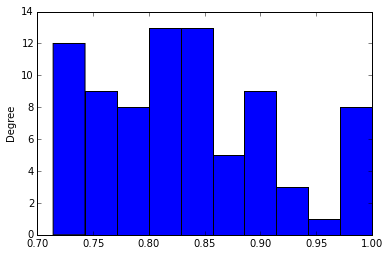

In [17]:
data[["_worker_id", "_trust"]].drop_duplicates()["_trust"].plot(kind = "hist")

### Check that the data are ok

In [18]:
data["_tainted"].value_counts()

False    4377
dtype: int64

In [19]:
v = defaultdict(set)
for val, group in data.groupby("uniq_id"):
    v[len(group)].add(val)
    
for i, j in v.items():
    print(i, len(j))

4 1
5 865
6 8


There is one work unit which did not receive 5 votes, but the task had majority votes, so there is no need to worry. Everything else had 5 or more votes due to my real-time adjustments to the test questions.

### Read the cached CID relations

In [20]:
cid_rels = save_file("../refinement/refine_run_1_cid_rels.pickle")

In [21]:
temp = defaultdict(list)
for pmid, vals in cid_rels.items():
    if vals:
        for chem, dise in vals:
            temp["pmid"].append(pmid)
            temp["chemical_id"].append(chem.flat_repr)
            temp["disease_id"].append(dise.flat_repr)
            temp["rel_origin"].append("cid")
            temp["num_votes"].append(5)
            
temp = pd.DataFrame(temp)

In [22]:
temp.head(2)

,chemical_id,disease_id,num_votes,pmid,rel_origin
0,MESH:D008094,MESH:D003919,5,7453952,cid
1,MESH:D008094,MESH:D059606,5,7453952,cid


### Aggregate results

In [23]:
raw_res = aggregate_results("uniq_id", "rel_resp", data, "positive_signal_only",
    ["pmid", "_unit_id", "chemical_id", "disease_id", "rel_origin"],
    "yes_direct")

In [24]:
raw_res = raw_res.query("rel_resp == 'yes_direct'")

In [25]:
raw_res.head()

,uniq_id,rel_resp,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,rel_origin
0,refine_try_1_0,yes_direct,0.0000,0,0.000000,7453952,857897838,MESH:D018021,MESH:D003919,abs
1,refine_try_1_1,yes_direct,0.9167,1,0.218987,7453952,857897839,MESH:D011188,MESH:D011141,abs
1,refine_try_1_10,yes_direct,0.7619,1,0.181504,2559236,857897848,MESH:D004656,MESH:D009401,sent
1,refine_try_1_100,yes_direct,2.5101,3,0.619609,7910951,857897941,MESH:D000305,MESH:D012131,abs
1,refine_try_1_101,yes_direct,1.4643,2,0.384391,7910951,857897942,MESH:D014673,MESH:D008107,abs


### Combine results

In [26]:
res = pd.concat([raw_res, temp])

In [27]:
res.head()

,chemical_id,conf_score,disease_id,num_votes,percent_agree,pmid,rel_origin,rel_resp,uniq_id,unit_id
0,MESH:D018021,0.0000,MESH:D003919,0,0.000000,7453952,abs,yes_direct,refine_try_1_0,857897838
1,MESH:D011188,0.9167,MESH:D011141,1,0.218987,7453952,abs,yes_direct,refine_try_1_1,857897839
1,MESH:D004656,0.7619,MESH:D009401,1,0.181504,2559236,sent,yes_direct,refine_try_1_10,857897848
1,MESH:D000305,2.5101,MESH:D012131,3,0.619609,7910951,abs,yes_direct,refine_try_1_100,857897941
1,MESH:D014673,1.4643,MESH:D008107,2,0.384391,7910951,abs,yes_direct,refine_try_1_101,857897942


## Evaluate performance

In [28]:
perf = official_F_score("num_votes", gold_relations, res)
perf

,F_score,precision,recall,threshold
0,0.311759,0.184665,1.000000,0
1,0.425974,0.273790,0.959064,1
2,0.530120,0.375610,0.900585,2
3,0.609244,0.475410,0.847953,3
4,0.628866,0.562212,0.713450,4
5,0.601266,0.655172,0.555556,5


In [29]:
def plot_results(res, title, xlabel, fontsize, figsize, linewidth, fname = None):
    res = res.sort("threshold")
    plt.rcParams.update({'font.size': fontsize})

    graph = res.plot(x = "threshold", figsize = figsize,
                     linewidth = linewidth, title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

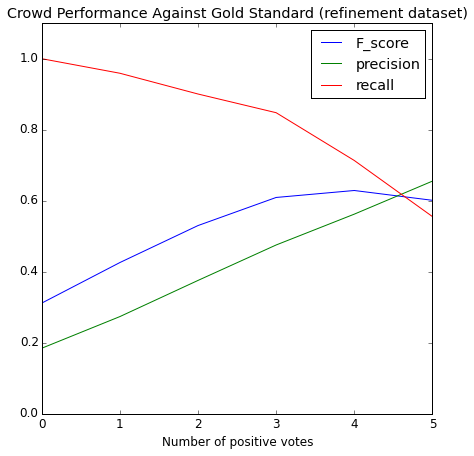

In [30]:
plot_results(perf, "Crowd Performance Against Gold Standard (refinement dataset)",
            "Number of positive votes", 12, (7, 7), 1)

Performance is again middling. It's very very similar to what we were getting before, especially after NER error filtering (0.6 F range). No major improvement compared to before.

---

## Error analysis

Where did the crowd go wrong and how can we improve performance?

In [31]:
res["in_gold"] = res.loc[:, TRIPLE].apply(
    lambda r:
        int((r["pmid"], r["chemical_id"], r["disease_id"]) in gold_relations),
    axis = 1
)

In [32]:
res.head()

,chemical_id,conf_score,disease_id,num_votes,percent_agree,pmid,rel_origin,rel_resp,uniq_id,unit_id,in_gold
0,MESH:D018021,0.0000,MESH:D003919,0,0.000000,7453952,abs,yes_direct,refine_try_1_0,857897838,0
1,MESH:D011188,0.9167,MESH:D011141,1,0.218987,7453952,abs,yes_direct,refine_try_1_1,857897839,0
1,MESH:D004656,0.7619,MESH:D009401,1,0.181504,2559236,sent,yes_direct,refine_try_1_10,857897848,0
1,MESH:D000305,2.5101,MESH:D012131,3,0.619609,7910951,abs,yes_direct,refine_try_1_100,857897941,0
1,MESH:D014673,1.4643,MESH:D008107,2,0.384391,7910951,abs,yes_direct,refine_try_1_101,857897942,0


In [33]:
res["cf"] = res["unit_id"].map(
    lambda v:
        "https://crowdflower.com/jobs/847908/units/{}".format(int(v) if not math.isnan(v) else v)
)

---

In [34]:
temp = dict()
for vote, group in res.groupby("num_votes"):
    temp[vote] = group["in_gold"].value_counts(normalize = True)
    
temp = pd.DataFrame(temp).T
temp["threshold"] = temp.index
temp = temp.rename(columns = {0: "not_gold", 1: "is_gold"})

temp["num"] = temp["threshold"].map(
    lambda f:
        len(res.query("num_votes == {}".format(f)))
)

In [35]:
temp

,not_gold,is_gold,threshold,num
0,0.978593,0.021407,0,327
1,0.947090,0.052910,1,189
2,0.914286,0.085714,2,105
3,0.738636,0.261364,3,88
4,0.625000,0.375000,4,72
5,0.344828,0.655172,5,145


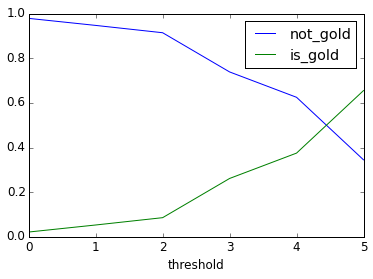

In [36]:
temp[["not_gold", "is_gold", "threshold"]].plot(x = "threshold")

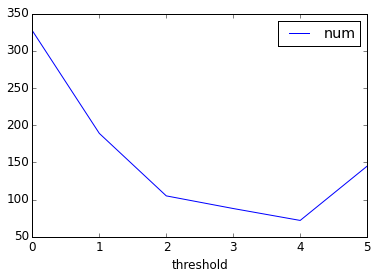

In [37]:
temp[["threshold", "num"]].plot(x = "threshold")

In [38]:
for i in range(6):
    print("votes:", i)
    print(res.query("num_votes == {}".format(i))["in_gold"].value_counts())
    print()

votes: 0
0    320
1      7
dtype: int64

votes: 1
0    179
1     10
dtype: int64

votes: 2
0    96
1     9
dtype: int64

votes: 3
0    65
1    23
dtype: int64

votes: 4
0    45
1    27
dtype: int64

votes: 5
1    95
0    50
dtype: int64



In [39]:
res.query("num_votes == 5 & in_gold == 1")["rel_origin"].value_counts()

sent    45
cid     36
abs     14
dtype: int64

In [40]:
res.query("num_votes == 5 & in_gold == 0")["rel_origin"].value_counts()

sent    25
cid     16
abs      9
dtype: int64

In [41]:
print(res.query("num_votes == 5 & in_gold == 0 & rel_origin == 'sent'").sample(10))

    chemical_id  conf_score    disease_id  num_votes  percent_agree      pmid  \
0  MESH:D000431      4.1310  MESH:D064420          5              1  12842176   
0  MESH:D005277      4.4777  MESH:D006349          5              1   9867728   
0  MESH:D016642      4.0215  MESH:D002318          5              1  11928786   
0  MESH:D003000      4.0454  MESH:D007022          5              1  15145918   
0  MESH:D007654      4.2620  MESH:D003643          5              1   3101906   
0  MESH:D002927      4.0564  MESH:D001145          5              1   8437969   
0  MESH:D001241      4.0772  MESH:D013274          5              1   6692345   
0  MESH:D008914      3.9235  MESH:D004194          5              1  12789195   
0  MESH:D010862      4.0774  MESH:D001930          5              1   9305828   
0  MESH:D001556      3.9384  MESH:D064420          5              1  12842176   

  rel_origin    rel_resp           uniq_id    unit_id  in_gold  \
0       sent  yes_direct  refine_try_1_606

In [43]:
res.query("pmid == 12789195")

,chemical_id,conf_score,disease_id,num_votes,percent_agree,pmid,rel_origin,rel_resp,uniq_id,unit_id,in_gold,cf
1,MESH:D008914,2.5682,MESH:D000172,3,0.575688,12789195,abs,yes_direct,refine_try_1_668,857898517,1,https://crowdflower.com/jobs/847908/units/857898517
1,MESH:D008914,1.6500,MESH:D004700,2,0.402891,12789195,abs,yes_direct,refine_try_1_669,857898518,0,https://crowdflower.com/jobs/847908/units/857898518
1,MESH:D008914,0.9000,MESH:D006984,1,0.206730,12789195,abs,yes_direct,refine_try_1_670,857898519,0,https://crowdflower.com/jobs/847908/units/857898519
1,MESH:D008914,0.8269,MESH:C535610,1,0.197389,12789195,abs,yes_direct,refine_try_1_671,857898520,0,https://crowdflower.com/jobs/847908/units/857898520
0,MESH:D008914,3.9235,MESH:D004194,5,1.000000,12789195,sent,yes_direct,refine_try_1_672,857898521,0,https://crowdflower.com/jobs/847908/units/857898521
